In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import regularizers

In [4]:
import keras

In [5]:
seed_value = 7

import os
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import random
random.seed(seed_value)

np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

import keras.backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [6]:
df=pd.read_csv(r"C:\Users\filip\OneDrive\Documents\Master 4.0\4. semestar\Masinsko ucenje\euroleague_dset_csv_03_20_upd.csv")

In [7]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%d.%m.%Y')

In [8]:
# Keep only instances from the last 5 seasons
df = df[df['DATE'].dt.year >= 2016]

In [9]:
# Drop the DATE column 
df = df.drop(columns=['DATE'])

In [10]:
# Replace secondary teams names in 'HT' column
df['HT'] = df['HT'].replace({'Crvena zvezda mts': 'Crvena Zvezda', 
                             'Anadolu Efes SK': 'Anadolu Efes',
                             'Fenerbahce Ulker': 'Fenerbahce',
                             'Khimki M.': 'Khimki'})

# Replace secondary teams names in 'AT' column
df['AT'] = df['AT'].replace({'Crvena zvezda mts': 'Crvena Zvezda', 
                             'Anadolu Efes SK': 'Anadolu Efes',
                             'Fenerbahce Ulker': 'Fenerbahce',
                             'Khimki M.': 'Khimki'})

# Replace secondary teams names in 'WINNER' column
df['WINNER'] = df['WINNER'].replace({'Crvena zvezda mts': 'Crvena Zvezda', 
                             'Anadolu Efes SK': 'Anadolu Efes',
                             'Fenerbahce Ulker': 'Fenerbahce',
                             'Khimki M.': 'Khimki'})

In [11]:
# Delete instances with Chinese teams as they are not part of the EuroLeague
df = df[(df['HT'] != 'Guandong') & (df['HT'] != 'Sichuan')]

In [12]:
# Get a list of all unique teams
unique_teams = set(df['HT'].unique()).union(set(df['AT'].unique()))

In [13]:
# Replace NaN values with 0 in 'OTH' and 'OTA'
df['OTH'].fillna(0, inplace=True)
df['OTA'].fillna(0, inplace=True)

# Add 'OTH' to 'Q4H' and 'OTA' to 'Q4A'
df['Q4H'] = (df['Q4H'] + df['OTH']).astype(int)
df['Q4A'] = (df['Q4A'] + df['OTA']).astype(int)

# Add 'OTH' to 'Q4H' and 'OTA' to 'Q4A'
df['P2H'] = (df['P2H'] + df['OTH']).astype(int)
df['P2A'] = (df['P2A'] + df['OTA']).astype(int)

In [14]:
# One-hot encode 'HT' and 'AT'
df = pd.get_dummies(df, columns=['HT', 'AT'], drop_first=True)

In [15]:
# Drop columns that are sums of other columns, overtime columns as they are now calculated in the 4th quarter column 
# and the target variable column

X = df.drop(columns=['WINNER', 'OTH', 'OTA', 'Q1T', 'Q2T', 'Q3T', 'Q4T', 'P1T', 'P2T', 'HTT', 'FTT', 'GAPT'])  

# 'WINNER' column is the target variable
Y = df['WINNER']

In [16]:
# One-hot encode Y
Y = pd.get_dummies(Y, drop_first=True)

In [17]:
# Split the data set on training and test sets
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, train_size=0.7, stratify = Y, random_state = 42)

In [18]:
# Create standardization scaler
scaler = StandardScaler()

In [19]:
# List all the numerical_columns
numerical_columns = ['HS', 'AS', 'Q1H', 'Q1A', 'Q2H', 'Q2A', 'Q3H', 'Q3A', 'Q4H', 'Q4A', 'P1H', 'P1A', 'P2H', 'P2A', 'GAPA1Q', 'GAPA2Q', 'GAPA3Q', 'GAPA4Q']

In [20]:
# Fit the scaler on training set
scaler.fit(x_train[numerical_columns])

StandardScaler()

In [21]:
# Transform training and test set with the standardization scaler
x_train[numerical_columns] = scaler.transform(x_train[numerical_columns])
x_test[numerical_columns] = scaler.transform(x_test[numerical_columns])

In [22]:
# Determine the size of input and output network layers
number_of_features = X.shape[1]
output_size = 26

In [23]:
# Create the network structure
model = Sequential([Input(shape=(number_of_features, )),
                    Dense(units=200, activation='relu'),
                    Dense(units=200, activation='relu'),
                    Dense(units=200, activation='relu'),
                    Dense(units=200, activation='relu'),
                    Dense(units=output_size, activation='sigmoid')
                   ])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               14200     
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 dense_3 (Dense)             (None, 200)               40200     
                                                                 
 dense_4 (Dense)             (None, 26)                5226      
                                                                 
Total params: 140026 (546.98 KB)
Trainable params: 140026 (546.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [26]:
# Create the model using Adam optimizer and BinaryCrossentropy loss function
model.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [27]:
# Train the model for 50 epochs
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
18/18 [==============================] - 1s 10ms/step - loss: 0.6773 - accuracy: 0.0422 - val_loss: 0.6448 - val_accuracy: 0.0280
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6110 - accuracy: 0.0264 - val_loss: 0.5617 - val_accuracy: 0.0280
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 0.5062 - accuracy: 0.0334 - val_loss: 0.4284 - val_accuracy: 0.0699
Epoch 4/100
18/18 [==============================] - 0s 2ms/step - loss: 0.3569 - accuracy: 0.0457 - val_loss: 0.2742 - val_accuracy: 0.0839
Epoch 5/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2252 - accuracy: 0.0756 - val_loss: 0.1859 - val_accuracy: 0.1049
Epoch 6/100
18/18 [==============================] - 0s 2ms/step - loss: 0.1715 - accuracy: 0.1125 - val_loss: 0.1669 - val_accuracy: 0.0979
Epoch 7/100
18/18 [==============================] - 0s 2ms/step - loss: 0.1610 - accuracy: 0.1388 - val_loss: 0.1631 - val_accuracy: 0.0769
Epoch 8/100


In [28]:
epochs = history.epoch
loss = history.history['loss']
validation_loss = history.history['val_loss']

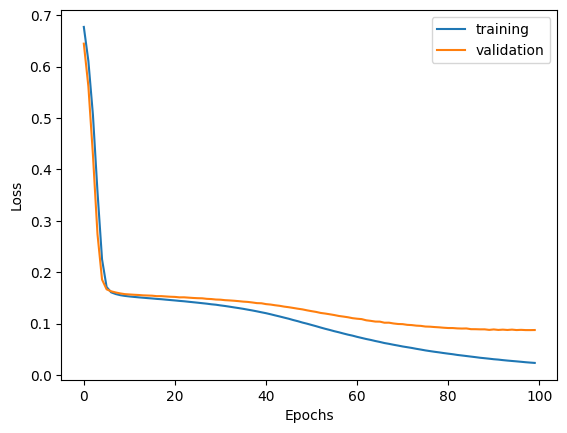

In [29]:
# Showing the change of the loss function over 50 epochs
plt.plot(epochs, loss, label='training')
plt.plot(epochs, validation_loss, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [30]:
acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

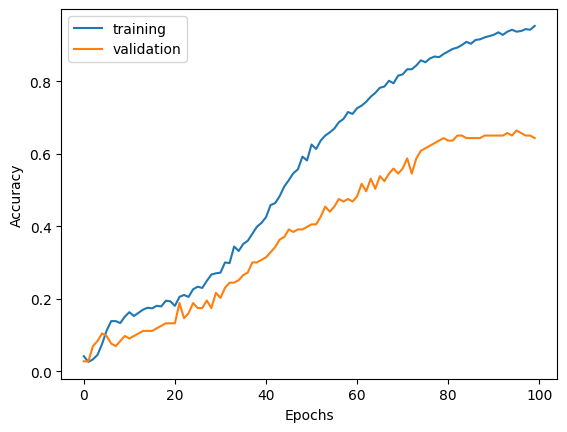

In [31]:
# Showing the change of the accuracy over 50 epochs
plt.plot(epochs, acc, label='training')
plt.plot(epochs, validation_acc, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [32]:
# Final model structure after evaluation
final_model = Sequential([Input(shape=(number_of_features, )),
                    Dense(units=200, activation='relu'),
                    Dense(units=200, activation='relu'),
                    Dense(units=200, activation='relu'),
                    Dense(units=200, activation='relu'),
                    Dense(units=output_size, activation='sigmoid')
                   ])

In [33]:
# Creating final model
final_model.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [34]:
# Training final model
history = final_model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)

In [35]:
# Final model evaluation on training set
train_scores = final_model.evaluate(x_train, y_train, batch_size=32)

23/23 [==============================] - 0s 734us/step - loss: 0.0162 - accuracy: 0.9789


In [36]:
# Final model evaluation on test set
test_scores = final_model.evaluate(x_test, y_test, batch_size=32)

10/10 [==============================] - 0s 872us/step - loss: 0.0776 - accuracy: 0.7190
